# ``eBOSS`` Quasar Luminosity Function

Initiate notebook.

In [1]:
from collections import OrderedDict
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from mpl_toolkits import mplot3d

from config import use_local_package

use_local_package("../../HorizonGRound/")

from horizonground.luminosity_modeller import (
    LuminosityFunctionModeller,
    quasar_luminosity_PLE_model,
    quasar_luminosity_hybrid_model,
)

Define parameter ranges.

In [2]:
REDSHIFT_RANGE = 0., 3.
MAGNITUDE_RANGE = -29.0, -20.6
DENSITY_RANGE = 10**(-9.225), 10**(-4.775)

## Luminosity function data

Load luminosity function data.

In [3]:
DATA_FILE = "../data/input/luminosity_function_in_redshift_bins.txt"

observables = None
with open(DATA_FILE, 'r') as data_file:
    observables = tuple(
        map(
            lambda var_name: var_name.strip(" "), 
            data_file.readline().strip("#").strip("\n").split(",")
        )
    )

raw_measurements = np.genfromtxt(DATA_FILE, unpack=True)
measurements = np.zeros_like(raw_measurements)
for var_idx, var_name in enumerate(observables):
    if var_name.startswith('lg_Phi'):
        measurements[var_idx] = 10**raw_measurements[var_idx]
    elif var_name.startswith('d_lg_Phi'):
        measurements[var_idx] = 10**raw_measurements[var_idx-1] \
            * (10**raw_measurements[var_idx] - 1)
    else:
        measurements[var_idx] = raw_measurements[var_idx]
    
luminosity_function_data = OrderedDict(zip(observables, measurements))

Determine redshift bins.

In [4]:
redshift_bin_labels = tuple(
    map(
        lambda redshift_range: r"${}$".format(redshift_range),
        [
            var_name.split("z_")[-1].replace("_", "<z<")
            for col_no, var_name in enumerate(luminosity_function_data) 
            if var_name.startswith('lg_Phi')
        ]
    )
)

redshift_bin_centres = tuple(
    map(
        lambda redshift_range: np.mean(
            list(map(lambda endpoint: float(endpoint), redshift_range))
        ),
        [
            var_name.split("z_")[-1].split("_")
            for col_no, var_name in enumerate(luminosity_function_data)
            if var_name.startswith('lg_Phi')
        ]
    )
)

redshift_bins = OrderedDict(zip(redshift_bin_labels, redshift_bin_centres))

## Luminosity function model

Specify luminosity function model.

In [5]:
modeller = LuminosityFunctionModeller.from_parameters_file(
    parameter_file="../data/input/PLE_model_fits.txt",
    luminosity_model=quasar_luminosity_PLE_model,
    luminosity_variable='magnitude',
    threshold_value=-21.80,
    threshold_variable='magnitude',
    cosmology=Planck15
)

luminosity_function_model = modeller.luminosity_function

Visualise luminosity function surface.

Text(0.5,0,'$\\Phi(m,z)$ [$\\textrm{Mpc}^{-3} \\textrm{mag}^{-1}$]')

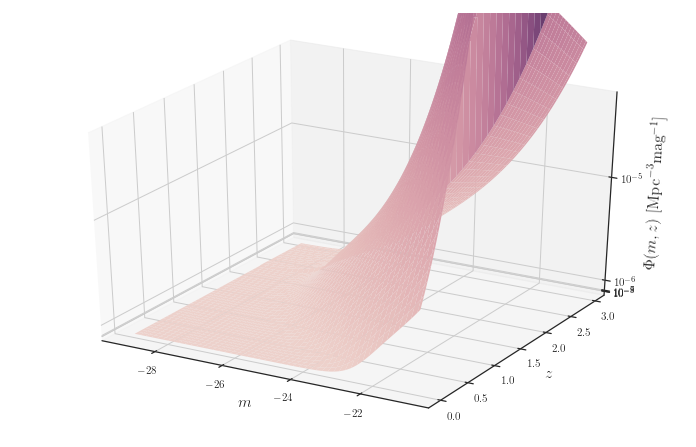

In [6]:
NUM_MESH = 100

magnitudes = np.linspace(*MAGNITUDE_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)
m, z = np.meshgrid(magnitudes, redshifts)
Phi = luminosity_function_model(m, z)

fig = plt.figure("Luminosity function surface", figsize=(12, 7.75))
ax = plt.axes(projection='3d')

ax.plot_surface(
    m, z, Phi,
    cmap=sns.cubehelix_palette(as_cmap=True),
    edgecolor='none'
)

ax.set_xlabel(r"$m$", fontsize=16)
ax.set_ylabel(r"$z$", fontsize=16)

ax.set_zlim(*DENSITY_RANGE)
ax.set_zscale('log')
ax.set_zlabel(r"$\Phi(m,z)$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]", fontsize=16)

## ``eBoss`` quasar luminosity function results

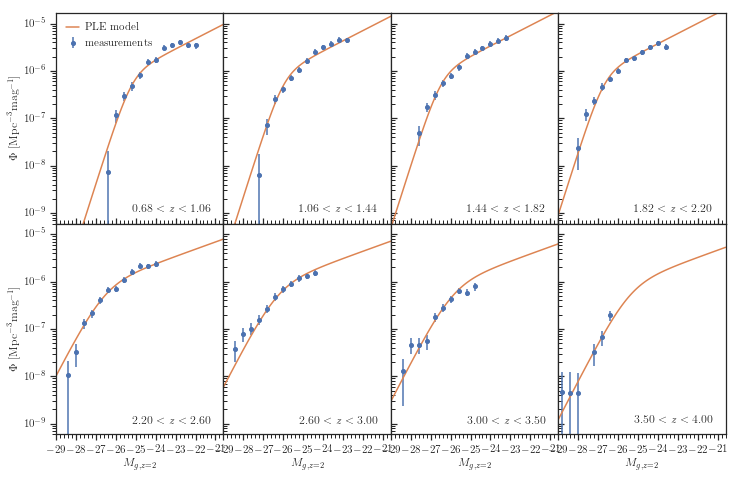

In [7]:
NUM_INTERVALS = 100

magnitude_points = np.linspace(*MAGNITUDE_RANGE, num=NUM_INTERVALS+1)

NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

LEGEND_SETTINGS = dict(
    loc='upper left',
    handlelength=1.2, 
    handletextpad=0.5
)

plt.figure("Luminosity function", figsize=(12, 7.75))
for bin_idx, (bin_label, bin_redshift) in enumerate(redshift_bins.items()):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), 
        (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, 
        colspan=COL_SPAN
    )
    
    if bin_idx == 0:
        plt.errorbar(
            luminosity_function_data['magnitude'],
            luminosity_function_data[observables[2*bin_idx+1]], 
            yerr=luminosity_function_data[observables[2*bin_idx+2]],
            fmt='o', markersize=4., capsize=0.,
            label='measurements'
        )
        plt.plot(
            magnitude_points, 
            luminosity_function_model(magnitude_points, bin_redshift)
                * Planck15.h**3,
            label='PLE model'
        )
        plt.legend(**LEGEND_SETTINGS)
    else:
        plt.errorbar(
            luminosity_function_data['magnitude'],
            luminosity_function_data[observables[2*bin_idx+1]], 
            yerr=luminosity_function_data[observables[2*bin_idx+2]],
            fmt='o', markersize=4., capsize=0.
        )
        plt.plot(
            magnitude_points,
            luminosity_function_model(magnitude_points, bin_redshift)
                * Planck15.h**3
        )        
    
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(
            axis='x', which='both', direction='in', 
            labelbottom=False, labelsize=2
        )
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(
            axis='y', which='both', direction='in',
            labelleft=False, labelsize=2
        )
    else:
        plt.ylabel(r"$\Phi$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")
    
    plt.title(bin_label, loc='right', position=(0.925, 0.025))

plt.subplots_adjust(hspace=0, wspace=0)